# Introduction

[*Critical Role*](https://en.wikipedia.org/wiki/Critical_Role) is "a show where a bunch of nerdy-ass voice actors play [*Dungeons and Dragons*](https://en.wikipedia.org/wiki/Dungeons_%26_Dragons)". CritRoleStats is a group of enthusiasts from the community that track and analyze different events of the game. In this project, I am going to explore their [*All Rolls - Tal'Dorei*](https://docs.google.com/spreadsheets/d/1OEg29XbL_YpO0m5JrLQpOPYTnxVsIg8iP67EYUrtRJg/edit?usp=sharing) table &mdash; a table of dice rolls for the whole Tal'Dorei campaign. My main focus will be d20 rolls.

Note: I already have quite a bit of familiarity with the data because a) I am a fan of the show, b) I've spent a long time cleaning up the table as a part of this project. Code for the cleanup can be viewed [here](https://nbviewer.jupyter.org/github/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei.ipynb) and can be downloaded [here](https://github.com/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei.ipynb). The cleaned-up table is [here](https://github.com/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei/Cleanish_All_Rolls_TalDorei.xlsx).

# Imports

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns


sns.set()
pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 500)

# Initializing a DataFrame

In [ ]:
df = pd.read_excel('drive/MyDrive/Cleanish_All_Rolls_TalDorei.xlsx'
                   , sheet_name='All Episodes')

# Make uncertain rolls certain; replace rolls for fun with 'Other'.
df['Type of Roll'].replace({'Alchemy?' : 'Alchemy',
                            'Arcana?' : 'Arcana',
                            'Athletics/Acrobatics' : 'Athletics',                           
                            'Persuasion?' : 'Persuasion',
                            'Wisdom Save?' : 'Wisdom Save',

                            'Disappointment' : 'Other',
                            'Determine Focus' : 'Other',
                            'Disguise Kit' : 'Other',
                            'Fart.' : 'Other',
                            'Panic' : 'Other',
                            'Test Roll' : 'Other',                           
                            'Trajectory' : 'Other',
                            'Unknown' : 'Other',
                            np.nan : 'Other',
                            }
                           , inplace=True
                          )

df['Total Value'] = df['Total Value'].fillna('Unknown')
df['Natural Value'] = df['Natural Value'].fillna('Unknown')
df['Character'] = df['Character'].fillna('Other')

# Basic information on columns

Columns:
1. **Episode** &mdash; id of an episode in which a roll happens. Categorical.
1. **Time** &mdash; timestamp of the roll. Continuous; represented as a string 'HH:MM:SS'.
1. **Character** &mdash; in-game name of the character who makes the roll. Categorical.
1. **Type of Roll** &mdash; an action on which a random decision is needed. For example, Attack, Persuasion, or Deception. Categorical.
1. **Total Value** &mdash; Natural Value + all bonuses the character has during the action. Mixed type: continuous values when known, empty or 'Unknown' otherwise. 
1. **Natural Value** &mdash; a value given by the dice. In a d20 (20-sided die) roll, often, 20 means automatic success, 1 means automatic failure (regardless of the total value). Mixed type: continuous values when known, empty or 'Unknown' otherwise. 
1. **Crit?** &mdash; whether a critical hit rolled (natural 20 on an Attack roll). Categorical: either 'Y' or empty.
1. **Damage** &mdash; value of damage of an attack and its target's name. I think these should be in two separate columns, but I prefer to just ignore this column. Mixed type.
1. **# Kills** &mdash; number of targets killed by an attack. Continuous.
1. **Notes** &mdash; some information about the roll.

In [ ]:
df.dtypes

Episode           object
Time              object
Character         object
Type of Roll      object
Total Value       object
Natural Value     object
Crit?             object
Damage            object
# Kills          float64
Notes             object
dtype: object

In [ ]:
df.head()

,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,# Kills,Notes
0,C1E001,0:37:53,Vex'ahlia,Intelligence,20,18,NaN,NaN,NaN,FIRST ROLL OMG
1,C1E001,0:41:48,Grog,Persuasion,19,18,NaN,NaN,NaN,NaN
2,C1E001,0:43:25,Keyleth,Persuasion,2,2,NaN,NaN,NaN,NaN
3,C1E001,0:46:35,Tiberius,Persuasion,12,3,NaN,NaN,NaN,Disregarded due to advantage
4,C1E001,0:46:35,Tiberius,Persuasion,27,18,NaN,NaN,NaN,With advantage


# d20 rolls: distribution

In Dungeons and Dragons, d20 (20-sided die) is the most utilized of the dice. It is used to determine whether some action of a character is successful, like whether the character noticed a stealthed enemy, or is able to hit the enemy, or whether he has access to some additional knowledge required to move the story. Usually, you roll a d20, add a bonus according to your character sheet, and check if the sum is greater or equal (success) or lower (failure) than the Difficulty Class (DC) for the skill check. There are two special roll values: 1 is an automatic failure and 20 is an automatic success (regardless of the bonuses and the DC).

## Preparing the dataframe

I'm only interested in d20 rolls made by the main cast of the show. Since Laura and Sam both roll for two characters, I am adding a column with players' names. I'm also filtering out invalid values seen in Natural Value column (anything outside of 1-20 and 'Unknown' is unacceptable).

In [ ]:
df['Natural Value'].unique()

array(['18', '2', '3', '15', '17', '6', '7', '8', '12', '13', '1',
       'Unknown', '4', '20', '10', '16', '14', '11', '9', '19', '5', '23',
       '21', '0', '22', '26', '24', '-4', '25', '-1'], dtype=object)

In [ ]:
# Characters of the main cast:
CHAR_LIST = ["Grog", "Keyleth", "Percy", "Pike", "Scanlan",
             "Taryon", "Tiberius", "Trinket", "Vax'ildan", "Vex'ahlia",
             ]

# Type of Roll to filter out:
NON_D20_TYPES = [
  'Beard Check', 'Bless', 'Damage', 'Determine Effect', 'Divine Intervention',
  'Gambit of Ord', 'Healing', "Heroes' Feast", 'Inspiration', 'Sleep Arrow',
  'Missile Snare', 'Other', 'Parry', 'Percentile', 'Potion Duration', 'Recharge', 
  'Second Wind',  
]

# Weird values in Natural Value column:
NATVAL_ERRS = [
  '0', '-1', '-4',
  '21', '22', '23', '24', '25', '26',
]

d20rolls = df[
   # Exclude weird values in Natural Value           
   ~df['Natural Value'].isin(NATVAL_ERRS)
   # Exclude non-d20 rolls 
   & ~df['Type of Roll'].isin(NON_D20_TYPES)
   # Filter for regular players' characters
   & df['Character'].isin(CHAR_LIST)
].copy()

# Replace character names with player names (some players have 2 characters):
d20rolls['Player'] = (d20rolls['Character']
                      .replace({"Keyleth" : "Marisha",
                                "Vax'ildan" : "Liam",
                                "Grog" : "Travis",
                                "Pike" : "Ashley",
                                "Percy" : "Taliesin",
                                "Tiberius" : "Orion",

                                "Scanlan" : "Sam",
                                "Taryon" : "Sam",
                                "Vex'ahlia" : "Laura",
                                "Trinket" : "Laura",
                                }
                              )
                      )

## A note on disregarded rolls

There are a number of modifications a player can make to a d20 roll. The ones I have to pay attention the most are those that allow the player to reroll the die, because the players often tell only the final number disregarding the other one. Those modifications are:
* the character has advantage &mdash; the player rolls twice, picks the **higher** number;
* the character has disadvantage &mdash; the player rolls twice, picks the **lower** number;
* [Lucky](http://dnd5e.wikidot.com/feat:lucky) feature of a character:
  > You have 3 luck points. Whenever you make an attack roll, an ability check, or a saving throw, you can spend one luck point to roll an additional d20. You can choose to spend one of your luck points after you roll the die, but before the outcome is determined. You choose which of the d20s is used for the attack roll, ability check, or saving throw. <br><br>
You regain your expended luck points when you finish a long rest.
* [Indomitable](https://roll20.net/compendium/dnd5e/Fighter#toc_16) ability of the Fighter class:
  > Beginning at 9th level, you can reroll a saving throw that you fail. If you do so, you must use the new roll, and you can't use this feature again until you finish a Long Rest.

  One of the players in *Critical Role* calls this ability *Resolve* (I don't know why).

The reason I need to keep track of these rolls, is that they are recorded but marked as *Unknown*. Since the lower numbers are disregarded more often (empirically; I'll show later), this introduces bias into the known rolls.

In the *All Rolls - Tal'Dorei* table, all these rolls are marked in the *Notes* column. Usually one note says "With ..." and the counterpart says "Disregarded due to ...". For example, "With advantage" and "Disregarded due to advantage" in Persuasion rolls made by Tiberius (shown below).

In [ ]:
d20rolls.head()

,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,# Kills,Notes,Player
0,C1E001,0:37:53,Vex'ahlia,Intelligence,20,18,NaN,NaN,NaN,FIRST ROLL OMG,Laura
1,C1E001,0:41:48,Grog,Persuasion,19,18,NaN,NaN,NaN,NaN,Travis
2,C1E001,0:43:25,Keyleth,Persuasion,2,2,NaN,NaN,NaN,NaN,Marisha
3,C1E001,0:46:35,Tiberius,Persuasion,12,3,NaN,NaN,NaN,Disregarded due to advantage,Orion
4,C1E001,0:46:35,Tiberius,Persuasion,27,18,NaN,NaN,NaN,With advantage,Orion


## d20 rolls' totals

In [ ]:
is_disregarded = d20rolls['Notes'].str.contains('isregard').fillna(False)

print('("Effective" means that the rolls were not disregarded.)\n')
print(f'd20 rolls, total: {len(d20rolls)}')
print(f'd20 rolls, effective: {len(d20rolls) - is_disregarded.sum()}')

("Effective" means that the rolls were not disregarded.)

d20 rolls, total: 10371
d20 rolls, effective: 8850


## Distribution of d20 rolls (unfiltered)

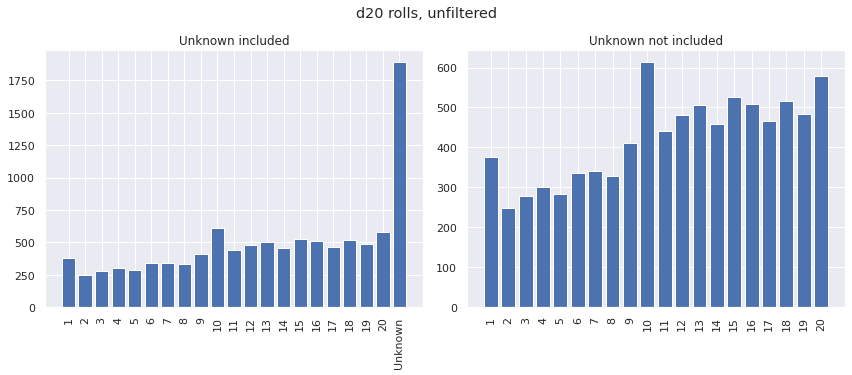

In [ ]:
in_order = [str(i) for i in range(1, 21)] + ['Unknown']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
axs[0].bar(np.arange(1, 22)
           , (d20rolls['Natural Value']
              .value_counts()[in_order]
              .values
             )
           , tick_label=in_order
          )
axs[0].set_title('Unknown included')
labels = axs[0].get_xticklabels()
plt.setp(labels, rotation=90)
axs[1].bar(np.arange(1, 21)
           , (d20rolls['Natural Value']
              .value_counts()[in_order[:-1]]
              .values
             )
           , tick_label=in_order[:-1]
          )
axs[1].set_title('Unknown not included')
labels = axs[1].get_xticklabels()
plt.setp(labels, rotation=90)
fig.suptitle('d20 rolls, unfiltered', y=1.04)

plt.tight_layout()
plt.show()

You can see several things on the graph:
1. A lot of unknown values.
1. There are spikes at 1 and 10 (and, maybe, 20).
1. The distribution is skewed towards higher numbers.

## Where bias comes from

In [ ]:
is_disadv = d20rolls['Notes'].str.contains('isadvantage').fillna(False)
# All notes that contain 'isadvantage' contain 'dvantage' as well. 
is_adv = (d20rolls['Notes'].str.contains('dvantage').fillna(False)
            & ~is_disadv
         )
is_luck = d20rolls['Notes'].str.contains('Luck').fillna(False)
is_indomitable = (d20rolls['Notes'].str.contains('ndomitable')
                    | d20rolls['Notes'].str.contains('esolve').fillna(False)
                 )
is_straight = ~(is_adv 
                | is_disadv 
                | is_luck 
                | is_indomitable
               )

print(f"""(\"Effective\" means that rolls were not disregarded.)

Positively biased rolls:
- d20 rolls, effective, with advantage: {(is_adv & ~is_disregarded).sum()}
- d20 rolls, effective, with Luck: {(is_luck & ~is_disregarded).sum()}
Total: {((is_adv | is_luck) & ~is_disregarded).sum()}

Negative bias sources:
- d20 rolls, effective, with disadvantage: {(is_disadv & ~is_disregarded).sum()}

Straight (uncoupled) rolls:
- d20 rolls, effective, no advantage, no disadvantage, no Luck, no Indomitable: {(is_straight 
                                                                                  & ~is_disregarded
                                                                                 ).sum()}""")

("Effective" means that rolls were not disregarded.)

Positively biased rolls:
- d20 rolls, effective, with advantage: 977
- d20 rolls, effective, with Luck: 130
Total: 1102

Negative bias sources:
- d20 rolls, effective, with disadvantage: 348

Straight (uncoupled) rolls:
- d20 rolls, effective, no advantage, no disadvantage, no Luck, no Indomitable: 7380


For 1107 rolls, the lower roll is dropped; for 348 rolls, the higher roll is dropped. I have not included Indomitable, because you *must* keep the roll, whether it is higher or lower &mdash; hence the bias is not introduced.

## Distribution of straight d20 rolls

Let's leave only effective straight rolls.

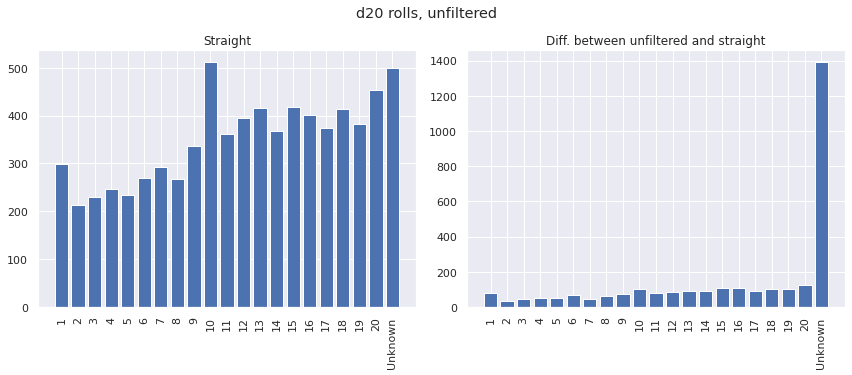

In [ ]:
diff = (d20rolls['Natural Value'].value_counts()
        - d20rolls.loc[is_straight
                       & ~is_disregarded
                       , 'Natural Value'
                      ].value_counts()
       )[in_order]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs = axs.flatten()
axs[0].bar(np.arange(1, 22)
           , (d20rolls.loc[is_straight
                           & ~is_disregarded
                           , 'Natural Value'
                          ].value_counts()[in_order]
                           .values
             )
           , tick_label=in_order
          )
axs[0].set_title('Straight')
labels = axs[0].get_xticklabels()
plt.setp(labels, rotation=90)
axs[1].bar(np.arange(1, 22)
           , diff.values
           , tick_label=in_order
          )
axs[1].set_title('Diff. between unfiltered and straight')
labels = axs[1].get_xticklabels()

plt.setp(labels, rotation=90)
fig.suptitle('d20 rolls, unfiltered', y=1.04)
plt.tight_layout()
plt.show()

The number of unknown rolls has diminished significantly; the skew towards higher numbers has diminished slightly.

I think I can explain the spike at 10.

## Considering Reliable talent
At level 11, as a Rogue, Vax'ildan acquires his [Reliable Talent](https://roll20.net/compendium/dnd5e/Rogue#toc_12) ability:
> By 11th level, you have refined your chosen Skills until they approach perfection. Whenever you make an ability check that lets you add your Proficiency Bonus, you can treat a d20 roll of 9 or lower as a 10.

Let's look at the rolls subject to this ability. According to [this table](https://docs.google.com/spreadsheets/d/1YxNsbZUcU_w670DslEi85_EJTGGcabhjRwJd5cTqfho/edit#gid=0) from CritRoleStats, Vax'ildan becomes level 11 Rogue at episode 20, and, according to [his character sheet](https://www.dropbox.com/sh/einw27b5zsyuvz4/AAByGWj0ZifFvR7ygSwLOJuqa?dl=0&preview=Vax%27ildan_L11.pdf), he is proficient in Acrobatics, Intimidation, Investigation, Perception, Persuasion, Sleight of Hand, and Stealth.

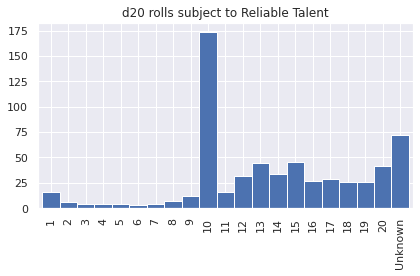

In [ ]:
is_after_ep19 = (d20rolls['Episode']
                 .isin(['C1E%03d' % i for i in range(20, 116)] 
                        + ['C1E031 p1', 'C1E031 p2', 
                           'C1E033 p1', 'C1E033 p2',
                           'C1E035 p1', 'C1E031 p2',
                          ]
                      )
)
is_vaxildans_proficiency = (d20rolls['Type of Roll']
                          .isin(['Acrobatics', 'Intimidation',
                                 'Investigation', 'Perception',
                                 'Persuasion', 'Sleight of Hand',
                                 'Stealth'
                                ]
                               )
)                 
is_reliable_talent = ((d20rolls['Character'] == "Vax'ildan")
                      & is_after_ep19
                      & is_vaxildans_proficiency
                     )

(
  d20rolls.loc[is_reliable_talent
               , 'Natural Value'
              ].value_counts()[in_order]
               .plot.bar(title='d20 rolls subject to Reliable Talent'
                         , width=1
                        )
)
plt.tight_layout()
plt.savefig('reliable_talent.png')
plt.show()

And there you have it: the spike at ten, the under-representation of the numbers lower than 10 (I wonder why they are there at all: either the player's mistake or bad records).

## Straight rolls without Reliable Talent

Let's see what the distribution looks like without Reliable Talent.

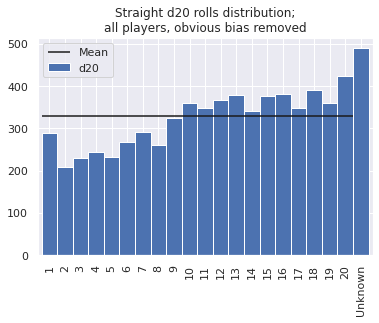

In [ ]:
counts = (d20rolls.loc[is_straight
                       & ~is_reliable_talent
                       , 'Natural Value'
                      ].value_counts()
)
(counts.loc[in_order]
       .plot(kind='bar'
             , title='Straight d20 rolls distribution;\n'
                     'all players, obvious bias removed'
             , width=1
             , label='d20'
            )
)

plt.hlines(counts.mean(), -0.5, 19.5, label='Mean')
plt.legend()
plt.savefig('obvious_bias_removed.png')

It is still skewed towards higher numbers. Well, I'm sorry to say, but this is as far as I can go at getting an unbiased sample without more information on Unknown values. Let's look at per-player distributions.

## Per-player distributions of d20 rolls: obvious sources of bias removed

### A pretty heatmap

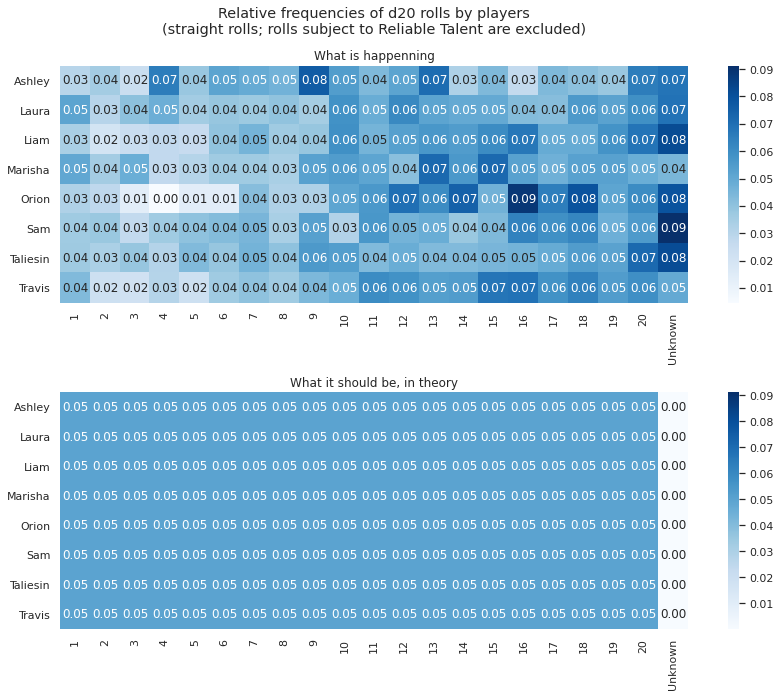

In [ ]:
natval_by_char = (d20rolls.assign(ones=1)
                  .loc[~is_disregarded
                       & is_straight 
                       & ~is_reliable_talent
                      ]
                  .pivot_table(index='Natural Value'
                               , columns='Player'
                               , values='ones'
                               , aggfunc='sum'
                              )
                  .fillna(0)
                 )
natval_by_char_rel = natval_by_char / natval_by_char.sum()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 9.25))
axs = axs.flatten()
fig.suptitle('Relative frequencies of d20 rolls by players\n'
             '(straight rolls; rolls subject to Reliable Talent are excluded)'
             , x=0.44
             , y=1.045
            )

sns.heatmap(natval_by_char_rel.loc[in_order].T
            , ax=axs[0]
            , cmap=sns.color_palette("Blues", as_cmap=True)
            , annot=True
            , fmt='.2f'
           )
axs[0].set_title('What is happenning')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

theoretical_dist = 0.05 * np.ones(natval_by_char.T.shape)
theoretical_dist[:, -1] = 0
sns.heatmap(theoretical_dist
            , ax=axs[1]
            , vmin=0
            , vmax=0.091232
            , xticklabels=in_order
            , yticklabels=sorted(natval_by_char.columns)
            , cmap=sns.color_palette("Blues", as_cmap=True)
            , cbar_kws=dict(ticks=0.01 * np.arange(1, 10))
            , annot=True
            , fmt='.2f'
           )
axs[1].set_title('What it should be, in theory')

plt.tight_layout()
plt.savefig('heatmap.png', bbox_inches='tight')

### Histograms

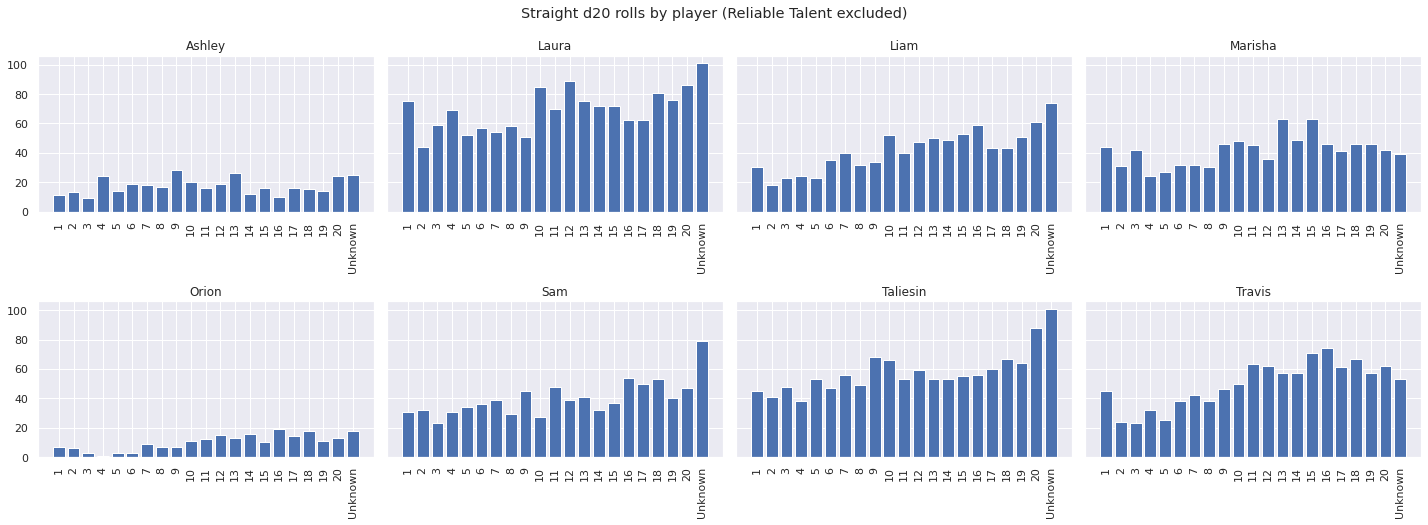

In [ ]:
players = sorted(d20rolls['Player'].unique())
samples = {player : d20rolls.loc[is_straight
                                 & ~is_reliable_talent
                                 & (d20rolls['Player'] == player)
                                 , 'Natural Value'
                                ].value_counts()
           for player in players
}

fig, axs = plt.subplots(nrows=2,
                        ncols=4,
                        figsize=(20, 7),
                        sharey=True
                        )
axs = axs.flatten()
for i, (player, ax) in enumerate(zip(players, axs)):
  counts = samples[player].loc[in_order]
  ax.bar(counts.index, counts.values)
  ax.set_xticklabels(in_order, Rotation=90)
  ax.set_title(player)
fig.suptitle('Straight d20 rolls by player (Reliable Talent excluded)'
             , y=1.04
            )
plt.tight_layout()
plt.savefig('straight_d20_by_player.png')

## Chi squared goodness-of-fit test

It is obvious that the distributions are far from uniform, but let's try a goodness-of-fit test for fun.

In [ ]:
print('\033[1m\033[4m' + 'Name'.ljust(9), 'p-value'.ljust(24), 'Sample size'.ljust(4) + '\033[0m')
for name, sample in samples.items():
  sample_no_unknown = []
  for element, quantity in sample.iteritems():
    if element != 'Unknown':
      sample_no_unknown.extend([int(element)] * quantity)
  print(name.ljust(9)
        , str(ss.chisquare(sample_no_unknown)[-1]).ljust(24)
        , str(len(sample_no_unknown)).ljust(4))

Name      p-value                  Sample size
Ashley    7.656585775871127e-61    341 
Laura     5.543624518415913e-269   1349
Liam      2.3624963846403155e-102  807 
Marisha   2.008243372943224e-145   833 
Orion     4.967045133952459e-16    198 
Sam       4.34192173389727e-137    768 
Taliesin  2.4973573592825092e-210  1119
Travis    8.897863207634361e-125   994 


The highest p-value is Orion's at about $5 \cdot 10^{-16}$. This means that there is $0.0000000000000005$ probability to have his distribution of d20 rolls by chance, assuming the distribution is uniform. For everybody else, it is even worse. I suspect that sample sizes affect the p-values the most.

**Note**

According to [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) of scipy.stats.chisquare:
> This test is invalid when the observed or expected frequencies in each category are too small. A typical rule is that all of the observed and expected frequencies should be at least 5.

At the graphs above, you can see that Orion has rolled 4 *exactly zero* times. This statistical test is actually invalid for his roll sample.

# Conclusion

I started this project with the intention to show with statistics, that Laura's notoriously superstitious behavior with her dice is doing nothing. Unfortunately, with available data, I cannot do this.

**Possible** explanations for why the data is skewed towards higher numbers:
1. *Many* values are unknown. Poor d20 rolls often go unannounced.
1. Systematic errors in data capturing. I have no idea.
1. Systematic errors made by the players (also known as cheating). I have no idea.
1. The dice used by the cast are actually unfair. I have no idea.